In [1]:
import torch
from diffusers import StableDiffusionPipeline, StableDiffusionImg2ImgPipeline, StableDiffusionInpaintPipelineLegacy, DDIMScheduler, AutoencoderKL
from PIL import Image
from ip_adapter import IPAdapter

/home/humw/anaconda3/envs/faceoff/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-08-31 18:46:09.814465: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-08-31 18:46:09.941625: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-08-31 18:46:09.972285: E tensorflow/stream_executor/cuda/cuda_blas.cc:2

In [2]:
base_model_path = "/home/humw/Pretrains/stable-diffusion-v1-5"
vae_model_path = "/home/humw/Pretrains/sd-vae-ft-mse"
image_encoder_path = "/home/humw/Pretrains/h94/IP-Adapter/models/image_encoder"
ip_ckpt = "/home/humw/Pretrains/h94/IP-Adapter/models/ip-adapter_sd15.bin"
device = "cuda:4"

In [3]:
def image_grid(imgs, rows, cols):
    assert len(imgs) == rows*cols

    w, h = imgs[0].size
    grid = Image.new('RGB', size=(cols*w, rows*h))
    grid_w, grid_h = grid.size
    
    for i, img in enumerate(imgs):
        grid.paste(img, box=(i%cols*w, i//cols*h))
    return grid

noise_scheduler = DDIMScheduler(
    num_train_timesteps=1000,
    beta_start=0.00085,
    beta_end=0.012,
    beta_schedule="scaled_linear",
    clip_sample=False,
    set_alpha_to_one=False,
    steps_offset=1,
)
vae = AutoencoderKL.from_pretrained(vae_model_path).to(dtype=torch.float16)

## Image Variations

In [4]:
# load SD pipeline
pipe = StableDiffusionPipeline.from_pretrained(
    base_model_path,
    torch_dtype=torch.float16,
    scheduler=noise_scheduler,
    vae=vae,
    feature_extractor=None,
    safety_checker=None
)

Loading pipeline components...: 100%|██████████| 5/5 [00:00<00:00,  6.26it/s]
You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


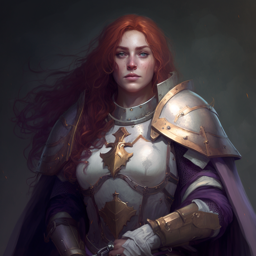

In [5]:
# read image prompt
image = Image.open("assets/images/woman.png")
image.resize((256, 256))

In [6]:
# refiner
# "/home/humw/Codes/FaceOff/output/VGGFace2_photomaker_max_out-512_refiner-blur3-min75-inter40_loss-n-mse_alpha6_eps16_num200/n000050/0012_01.png"
img_path = '/home/humw/Codes/FaceOff/output/VGGFace2_photomaker_max_out-512_refiner-blur3-min75-inter40_loss-n-mse_alpha6_eps16_num200/n000057/0012_01.png'
image = Image.open(img_path)
image.resize((256, 256))

FileNotFoundError: [Errno 2] No such file or directory: '/home/humw/Codes/FaceOff/output/VGGFace2_photomaker_max_out-512_refiner-blur3-min75-inter40_loss-n-mse_alpha6_eps16_num200/n000057/0012_01.png'

In [8]:
# load ip-adapter
ip_model = IPAdapter(pipe, image_encoder_path, ip_ckpt, device)

/home/humw/Codes/FaceOff/customization/target_model/IP-Adapter/ip_adapter/ip_adapter.py:134: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(self.ip_ck

In [9]:
# generate image variations
images = ip_model.generate(pil_image=image, num_samples=4, num_inference_steps=50, seed=42)
grid = image_grid(images, 1, 4)
grid

100%|██████████| 50/50 [00:08<00:00,  6.20it/s]


OutOfMemoryError: CUDA out of memory. Tried to allocate 512.00 MiB. GPU 4 has a total capacity of 23.69 GiB of which 243.88 MiB is free. Process 4096021 has 18.71 GiB memory in use. Process 965124 has 4.73 GiB memory in use. Of the allocated memory 4.14 GiB is allocated by PyTorch, and 284.95 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [ ]:
# generate image variations
images = ip_model.generate(pil_image=image, num_samples=4, num_inference_steps=50, seed=42)
save_prompt_dir = '/home/humw/Codes/FaceOff/target_model/IP-Adapter-main/output'
import os
save_path = os.path.join(save_prompt_dir, 'n000057_no_refiner')
os.makedirs(save_path, exist_ok=True)
for idx, image in enumerate(images):
    image.save(os.path.join(save_path, f"ipadapter_{idx:02d}.png"))
grid = image_grid(images, 1, 4)
grid

In [ ]:
# generate image variations
images = ip_model.generate(pil_image=image, num_samples=4, num_inference_steps=50, seed=42)
grid = image_grid(images, 1, 4)
grid

In [ ]:
# generate image variations
images = ip_model.generate(pil_image=image, num_samples=4, num_inference_steps=50, seed=42)
grid = image_grid(images, 1, 4)
grid

## Image-to-Image

In [ ]:
# load SD Img2Img pipe
del pipe, ip_model
torch.cuda.empty_cache()
pipe = StableDiffusionImg2ImgPipeline.from_pretrained(
    base_model_path,
    torch_dtype=torch.float16,
    scheduler=noise_scheduler,
    vae=vae,
    feature_extractor=None,
    safety_checker=None
)

In [ ]:
# read image prompt
image = Image.open("assets/images/river.png")
g_image = Image.open("assets/images/vermeer.jpg")
image_grid([image.resize((256, 256)), g_image.resize((256, 256))], 1, 2)

In [ ]:
# load ip-adapter
ip_model = IPAdapter(pipe, image_encoder_path, ip_ckpt, device)

In [ ]:
# generate
images = ip_model.generate(pil_image=image, num_samples=4, num_inference_steps=50, seed=42, image=g_image, strength=0.6)
grid = image_grid(images, 1, 4)
grid

## Inpainting

In [ ]:
# load SD Inpainting pipe
del pipe, ip_model
torch.cuda.empty_cache()
pipe = StableDiffusionInpaintPipelineLegacy.from_pretrained(
    base_model_path,
    torch_dtype=torch.float16,
    scheduler=noise_scheduler,
    vae=vae,
    feature_extractor=None,
    safety_checker=None
)

In [ ]:
# read image prompt
image = Image.open("assets/images/girl.png")
image.resize((256, 256))

In [ ]:
masked_image = Image.open("assets/inpainting/image.png").resize((512, 768))
mask = Image.open("assets/inpainting/mask.png").resize((512, 768))
image_grid([masked_image.resize((256, 384)), mask.resize((256, 384))], 1, 2)

In [ ]:
# load ip-adapter
ip_model = IPAdapter(pipe, image_encoder_path, ip_ckpt, device)

In [ ]:
# generate
images = ip_model.generate(pil_image=image, num_samples=4, num_inference_steps=50,
                           seed=42, image=masked_image, mask_image=mask, strength=0.7, )
grid = image_grid(images, 1, 4)
grid